# Composite symbols into component
In this example we will show how to make an Inception network by forming single symbol into component.

Inception is currently best model. Compared to other models, it has much less parameters, and with best performance. However, it is much more complex than sequence feedforward network.

The Inception network in this example is refer to ```Ioffe, Sergey, and Christian Szegedy. "Batch normalization: Accelerating deep network training by reducing internal covariate shift." arXiv preprint arXiv:1502.03167 (2015).```



In [1]:
import mxnet as mx

For complex network such as inception network, building from single symbol is painful, we can make simple ```ComponentFactory``` to simplfiy the procedure.

Except difference in number of filter, we find 2 major differences in each Inception module, so we can build two factories plus one basic ```Convolution + BatchNorm + ReLU``` factory to simplfiy the problem.


In [2]:
# Basic Conv + BN + ReLU factory
def ConvFactory(data, num_filter, kernel, stride=(1,1), pad=(0, 0), act_type="relu"):
    conv = mx.symbol.Convolution(data=data, num_filter=num_filter, kernel=kernel, stride=stride, pad=pad)
    bn = mx.symbol.BatchNorm(data=conv)
    act = mx.symbol.Activation(data = bn, act_type=act_type)
    return act


We can visualize our basic component

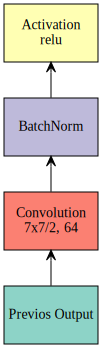

In [3]:
prev = mx.symbol.Variable(name="Previos Output")
conv_comp = ConvFactory(data=prev, num_filter=64, kernel=(7,7), stride=(2, 2))
mx.viz.plot_network(symbol=conv_comp)

The next step is making a component factory with all ```stride=(1, 1)```

In [4]:
# param mapping to paper:
# num_1x1      >>>  #1x1
# num_3x3red   >>>  #3x3 reduce
# num_3x3      >>>  #3x3
# num_d3x3red  >>>  double #3x3 reduce
# num_d3x3     >>>  double #3x3
# pool         >>>  Pool
# proj         >>>  proj
def InceptionFactoryA(data, num_1x1, num_3x3red, num_3x3, num_d3x3red, num_d3x3, pool, proj):
    # 1x1
    c1x1 = ConvFactory(data=data, num_filter=num_1x1, kernel=(1, 1))
    # 3x3 reduce + 3x3
    c3x3r = ConvFactory(data=data, num_filter=num_3x3red, kernel=(1, 1))
    c3x3 = ConvFactory(data=c3x3r, num_filter=num_3x3, kernel=(3, 3), pad=(1, 1))
    # double 3x3 reduce + double 3x3
    cd3x3r = ConvFactory(data=data, num_filter=num_d3x3red, kernel=(1, 1))
    cd3x3 = ConvFactory(data=cd3x3r, num_filter=num_d3x3, kernel=(3, 3), pad=(1, 1))
    # pool + proj
    pooling = mx.symbol.Pooling(data=data, kernel=(3, 3), stride=(1, 1), pad=(1, 1), pool_type=pool)
    cproj = ConvFactory(data=pooling, num_filter=proj, kernel=(1, 1))
    # concat
    concat = mx.symbol.Concat(*[c1x1, c3x3, cd3x3, cproj])
    return concat

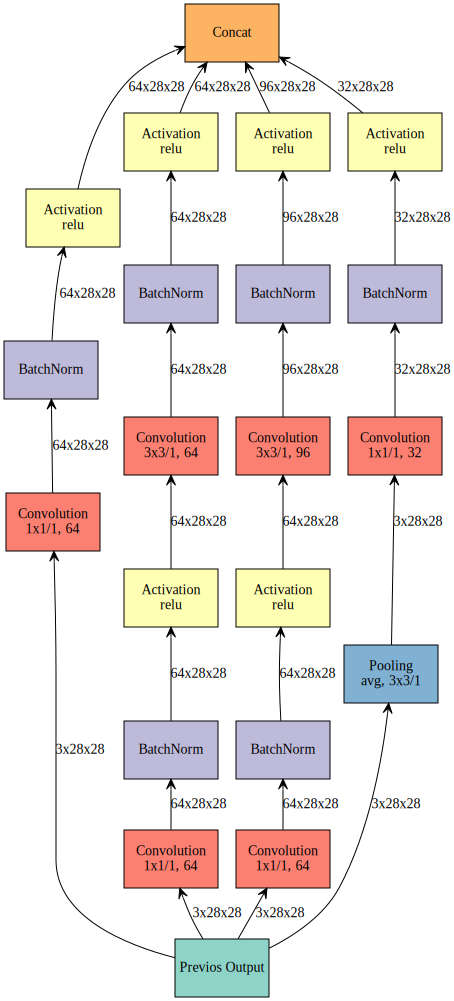

In [5]:
# We can also visualize network with feature map shape information
# In this case, we must provide all necessary input shape info as a dict
prev = mx.symbol.Variable(name="Previos Output")
in3a = InceptionFactoryA(prev, 64, 64, 64, 64, 96, "avg", 32)
# shape info
# Note shape info must contain batch size although we ignore batch size in graph to save space
batch_size = 128
shape = {"Previos Output" : (batch_size, 3, 28, 28)}
# plot
mx.viz.plot_network(symbol=in3a, shape=shape)

We will make the other factory with ```strde=(2, 2)```

In [6]:
# param mapping to paper:
# num_1x1      >>>  #1x1 (not exist!)
# num_3x3red   >>>  #3x3 reduce
# num_3x3      >>>  #3x3
# num_d3x3red  >>>  double #3x3 reduce
# num_d3x3     >>>  double #3x3
# pool         >>>  Pool (not needed, all are max pooling)
# proj         >>>  proj (not exist!)
def InceptionFactoryB(data, num_3x3red, num_3x3, num_d3x3red, num_d3x3):
    # 3x3 reduce + 3x3
    c3x3r = ConvFactory(data=data, num_filter=num_3x3red, kernel=(1, 1))
    c3x3 = ConvFactory(data=c3x3r, num_filter=num_3x3, kernel=(3, 3), pad=(1, 1), stride=(2, 2))
    # double 3x3 reduce + double 3x3
    cd3x3r = ConvFactory(data=data, num_filter=num_d3x3red, kernel=(1, 1))
    cd3x3 = ConvFactory(data=cd3x3r, num_filter=num_d3x3, kernel=(3, 3), pad=(1, 1), stride=(2, 2))
    # pool + proj
    pooling = mx.symbol.Pooling(data=data, kernel=(3, 3), stride=(2, 2), pool_type="max")
    # concat
    concat = mx.symbol.Concat(*[c3x3, cd3x3, pooling])
    return concat

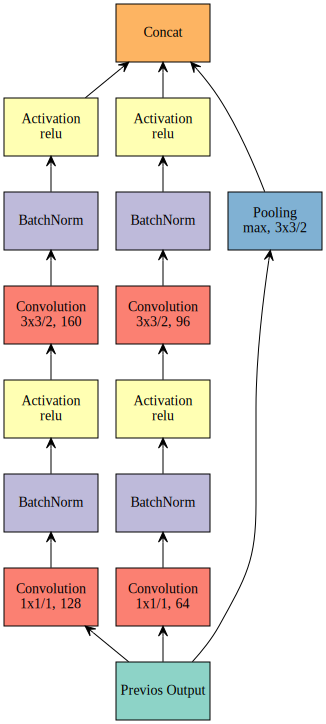

In [7]:
prev = mx.symbol.Variable(name="Previos Output")
in3c = InceptionFactoryB(prev, 128, 160, 64, 96)
mx.viz.plot_network(symbol=in3c)

Now we can use these factories to build the whole network

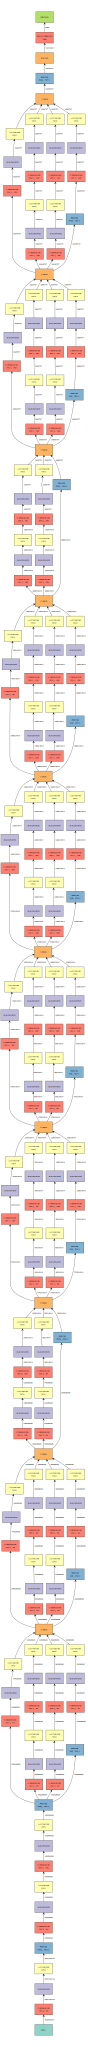

In [8]:
# data
data = mx.symbol.Variable(name="data")
# stage 1
conv1 = ConvFactory(data=data, num_filter=64, kernel=(7, 7), stride=(2, 2), pad=(3, 3))
pool1 = mx.symbol.Pooling(data=conv1, kernel=(3, 3), stride=(2, 2))
# stage 2
conv2red = ConvFactory(data=pool1, num_filter=64, kernel=(1, 1), stride=(1, 1))
conv2 = ConvFactory(data=conv2red, num_filter=192, kernel=(3, 3), stride=(1, 1), pad=(1, 1))
pool2 = mx.symbol.Pooling(data=conv2, kernel=(3, 3), stride=(2, 2))
# stage 3
in3a = InceptionFactoryA(pool2, 64, 64, 64, 64, 96, "avg", 32)
in3b = InceptionFactoryA(in3a, 64, 64, 96, 64, 96, "avg", 64)
in3c = InceptionFactoryB(in3b, 128, 160, 64, 96)
# stage 4
in4a = InceptionFactoryA(in3c, 224, 64, 96, 96, 128, "avg", 128)
in4b = InceptionFactoryA(in4a, 192, 96, 128, 96, 128, "avg", 128)
in4c = InceptionFactoryA(in4b, 160, 128, 160, 128, 160, "avg", 128)
in4d = InceptionFactoryA(in4c, 96, 128, 192, 160, 192, "avg", 128)
in4e = InceptionFactoryB(in4d, 128, 192, 192, 256)
# stage 5
in5a = InceptionFactoryA(in4e, 352, 192, 320, 160, 224, "avg", 128)
in5b = InceptionFactoryA(in5a, 352, 192, 320, 192, 224, "max", 128)
# global avg pooling
avg = mx.symbol.Pooling(data=in5b, kernel=(7, 7), stride=(1, 1), name="global_avg")
# linear classifier
flatten = mx.symbol.Flatten(data=avg)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=1000)
softmax = mx.symbol.Softmax(data=fc1)

# if you like, you can visualize full network structure
mx.visualization.plot_network(symbol=softmax, shape={"data" : (128, 3, 224, 224)})